In [2]:
#Angiogenic Tumor Model imports
from TumorAngiogenesisSynchro import Tissue
from TumorAngiogenesisSynchro import CellType
from TumorAngiogenesisSynchro import Therapy
from TumorAngiogenesisSynchro import TherapyType

#Angiogenesis model imports 
from BloodVesselGraph import AutomatonToGraph
from BloodVesselGraph import BloodVesselGraph
from BloodVesselGraph import GraphSketchType

#Other utilities
import numpy as np
import matplotlib.pyplot as plt
#import tikzplotlib
import csv
from matplotlib import rc


### 1.- Example angiogenesis network 

In [2]:
#Open the avascular tumor
automatonWidth = 150
automatonHeight = 150

tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance("avascular_instance.pkl")

#Evolving the automaton is easier now!
evolutionSteps = 200
tumor.setVascularPhase()
tumor.continueTumorEvolution(evolutionSteps, True, True, True, True)

#Let's export it just to have a sample
tumor.exportTumorInstance("vascular_tumor_sample.pkl")

100%|█████████████████████████████████████████| 200/200 [02:27<00:00,  1.36it/s]


Tumor object saved to vascular_tumor_sample.pkl


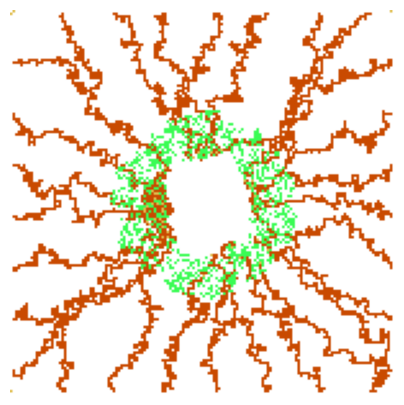

In [3]:
plt.figure(figsize = (5,5))
plt.imshow(tumor.networkMovie[:,:,:,-2])
plt.axis("off")

plt.savefig('Figures/automaton_angiogenesis.pdf', format='pdf', dpi=600, bbox_inches='tight')
#tikzplotlib.save("tikz_pictures/automaton_angiogenesis.tex")

### 2.- Example angiogenesis network graph 

100%|█████████████████████████████████████| 1096/1096 [00:00<00:00, 1456.79it/s]


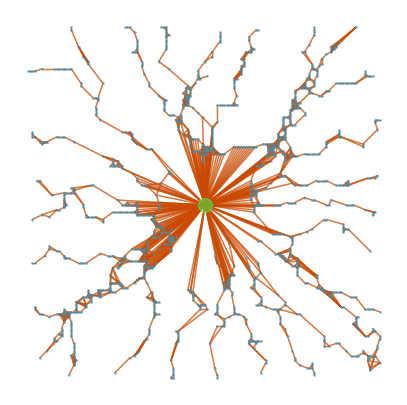

In [5]:
automatonToGraph = AutomatonToGraph()
occupiedCells = tumor.angiogenesisModule.occupiedCells
proliferatingPositions = tumor.getProliferatingLocations()

bloodVesselNetwork = automatonToGraph.convertAutomatonToGraphWithTumor(occupiedCells, proliferatingPositions)

plt.figure(figsize = (5,5))
bloodVesselNetwork.drawGraph(1,plt.gca(),GraphSketchType.ORIGINAL)
plt.axis('off')
#plt.gca().invert_yaxis()
plt.savefig('Figures/graph_angiogenesis.pdf',bbox_inches='tight', format='pdf', dpi=600)
#tikzplotlib.save("tikz_pictures/graph_angiogenesis.tex")


### 3.- Example post-angiogenesis growth automaton pictures (no therapy)

In [9]:
nSlices = 6
nEvolutionSteps = 200
frameIndexes = []
currentIndex = 0
indexDelta = int(nEvolutionSteps/nSlices)

for i in range(0,nSlices):
    currentIndex = currentIndex + indexDelta
    frameIndexes.append(200+currentIndex)
    

#Load the vascular tumor
vascularTumor = Tissue(automatonWidth, automatonHeight)
vascularTumor.importTumorInstance("vascular_tumor.pkl")

tumor.continueTumorEvolution(nEvolutionSteps, True, True, True, True)


100%|█████████████████████████████████████████| 200/200 [02:43<00:00,  1.22it/s]


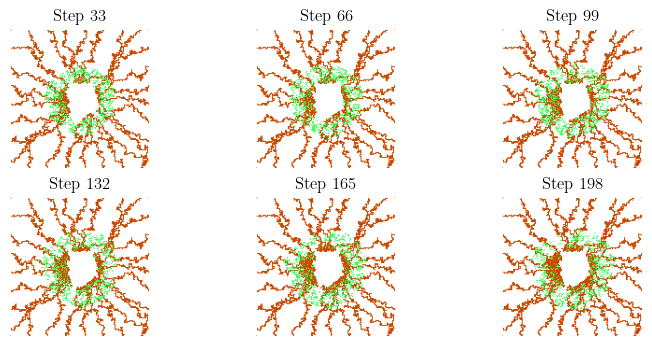

In [13]:
#Draw different steps of the evolution
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('axes', labelsize=20) 
rc('xtick', labelsize=14)
rc('ytick',labelsize = 14)

slices = tumor.networkMovie[:,:,:,:]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3

    
    frame = slices[:,:,:,frameIndex]

    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 200 ))
fig.savefig('Figures/tumor_growth_automaton_example.pdf', format='pdf', dpi=600, bbox_inches='tight')
#tikzplotlib.save("tikz_pictures/tumor_growth_automaton_example.tex")


### 4.- Example post-angiogenesis growth automaton pictures (radiotherapy)

In [14]:
#Define the therapy 
startDay = 401
g0Gamma = 0.05
alpha = 0.1
beta = 0.05
cycleTime = 4
dose = 1
thresholdOxygen = 0.35
delayTime = 50
initMitoticProb = 0.2
finalMitoticProb = 0.5

radiotherapy = Therapy(TherapyType.RADIOTHERAPY, startDay, g0Gamma, alpha, beta, cycleTime, dose, thresholdOxygen, delayTime, initMitoticProb, finalMitoticProb)

In [15]:
#Graow the tumor with the therapy
nSlices = 6
nEvolutionSteps = 200
frameIndexes = []
currentIndex = 0
indexDelta = int(nEvolutionSteps/nSlices)

for i in range(0,nSlices):
    currentIndex = currentIndex + indexDelta
    frameIndexes.append(200+currentIndex)
    

#Load the vascular tumor
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance("vascular_tumor.pkl")

#Add the therapy
tumor.addTherapy(radiotherapy)

#Angiogenesis-evolution of the tumor while a treatment is applied
tumor.continueTumorEvolution(nEvolutionSteps, True, True, True, True)



100%|█████████████████████████████████████████| 200/200 [02:36<00:00,  1.28it/s]


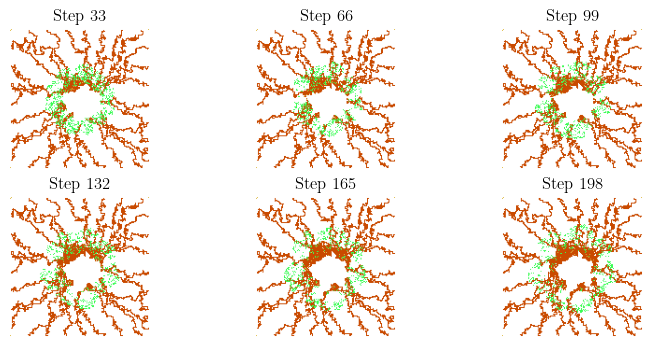

In [17]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('axes', labelsize=20) 
rc('xtick', labelsize=14)
rc('ytick',labelsize = 14)

slices = tumor.networkMovie[:,:,:,:]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]

    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 200 ))
fig.savefig('Figures/tumor_growth_automaton_example_radiotherapy.pdf', format='pdf', dpi=600, bbox_inches='tight')
    

### 5.- Example post-angiogenesis growth automaton pictures (VDA therapy)

In [1]:
def readCSVColumn(path, colNum):
    colData = []
    
    with open(path, 'r') as file:
        csvreader = csv.reader(file)
        i = 0
        for row in csvreader:
            if(i > 0):
                colData.append(float(row[colNum]))
            i = i + 1
    
    return colData

#### VDA therapy targetting nodes with maximum values for the metric

In [8]:
nSlices = 6
nEvolutionSteps = 200
frameIndexes = []
currentIndex = 0
indexDelta = int(nEvolutionSteps/nSlices)
automatonWidth = 150
automatonHeight = 150

for i in range(0,nSlices):
    currentIndex = currentIndex + indexDelta
    frameIndexes.append(200+currentIndex)

#Network that will be treated with VDA for nodes with maximum degree centrality
networkToTreat = 99
tumorPath = "bloodvessel_objects/" + "tumor_"+str(networkToTreat)+".pkl"
networkMetricsSrc = "network_metrics/"+"network_"+str(networkToTreat)+".csv"
nAttackedNodes = 10

#Open the tumor
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance(tumorPath)

tumorEvolutionSteps = 200

graphTransformer = AutomatonToGraph()
automatonToGraph = AutomatonToGraph()
occupiedCells = tumor.angiogenesisModule.occupiedCells
proliferatingPositions = tumor.getProliferatingLocations()

bloodVesselNetwork = graphTransformer.convertAutomatonToGraphWithTumor(occupiedCells, proliferatingPositions)

#Nodes with max degree centrality
metricIndex = 0

#Design the therapy using the nodes to target
nodeNumbersToTarget = readCSVColumn(networkMetricsSrc, metricIndex)
nodeNumbersToTarget = nodeNumbersToTarget[0:nAttackedNodes]
    
locationsToTreat = np.zeros((automatonHeight, automatonWidth))
for j in range(0,len(nodeNumbersToTarget)):
    nodeIndex = nodeNumbersToTarget[j]
    node = bloodVesselNetwork.nodes[int(nodeIndex)]
    automatonIndex1 = node.automatonIndex1
    automatonIndex2 = node.automatonIndex2
    locationsToTreat[automatonIndex1, automatonIndex2] = 1
        
    
startDay = 401
vesselKillThreshold = 0.04
potentialConstant = 1
sourceAmplification = 2
stepDeathProbability = 0.1

angioTherapy = Therapy(TherapyType.VDA, startDay, locationsToTreat, vesselKillThreshold, potentialConstant, sourceAmplification, stepDeathProbability)
tumor.addTherapy(angioTherapy)
tumor.continueTumorEvolution(tumorEvolutionSteps, True, True, True, True)


100%|█████████████████████████████████████████| 200/200 [02:37<00:00,  1.27it/s]


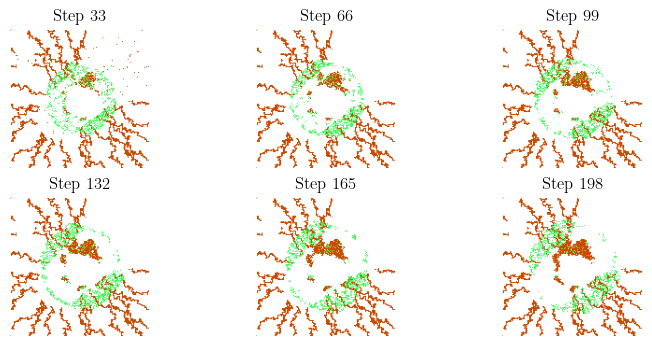

In [9]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('axes', labelsize=20) 
rc('xtick', labelsize=14)
rc('ytick',labelsize = 14)
slices = tumor.networkMovie[:,:,:,:]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]

    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 200 ))
fig.savefig('Figures/vda_automaton_example_max.pdf', format='pdf', dpi=600, bbox_inches='tight')

#tikzplotlib.save("tikz_pictures/antio_angiogenic_automaton_example_max.tex")

#### VDA therapy targetting nodes with minimumvalues for the metric

In [10]:
nSlices = 6
nEvolutionSteps = 200
frameIndexes = []
currentIndex = 0
indexDelta = int(nEvolutionSteps/nSlices)
automatonWidth = 150
automatonHeight = 150

for i in range(0,nSlices):
    currentIndex = currentIndex + indexDelta
    frameIndexes.append(200+currentIndex)

#Network that will be treated with VDA for nodes with maximum degree centrality
networkToTreat = 99
tumorPath = "bloodvessel_objects/" + "tumor_"+str(networkToTreat)+".pkl"
networkMetricsSrc = "network_metrics/"+"network_"+str(networkToTreat)+".csv"
nAttackedNodes = 10

#Open the tumor
tumor = Tissue(automatonWidth, automatonHeight)
tumor = tumor.importTumorInstance(tumorPath)

tumorEvolutionSteps = 200

graphTransformer = AutomatonToGraph()
automatonToGraph = AutomatonToGraph()
occupiedCells = tumor.angiogenesisModule.occupiedCells
proliferatingPositions = tumor.getProliferatingLocations()

bloodVesselNetwork = graphTransformer.convertAutomatonToGraphWithTumor(occupiedCells, proliferatingPositions)

#Nodes with max degree centrality
metricIndex = 5

#Design the therapy using the nodes to target
nodeNumbersToTarget = readCSVColumn(networkMetricsSrc, metricIndex)
nodeNumbersToTarget = nodeNumbersToTarget[0:nAttackedNodes]
    
locationsToTreat = np.zeros((automatonHeight, automatonWidth))
for j in range(0,len(nodeNumbersToTarget)):
    nodeIndex = nodeNumbersToTarget[j]
    node = bloodVesselNetwork.nodes[int(nodeIndex)]
    automatonIndex1 = node.automatonIndex1
    automatonIndex2 = node.automatonIndex2
    locationsToTreat[automatonIndex1, automatonIndex2] = 1
        
    
startDay = 401
vesselKillThreshold = 0.04
potentialConstant = 1
sourceAmplification = 2
stepDeathProbability = 0.1

angioTherapy = Therapy(TherapyType.VDA, startDay, locationsToTreat, vesselKillThreshold, potentialConstant, sourceAmplification, stepDeathProbability)
tumor.addTherapy(angioTherapy)
tumor.continueTumorEvolution(tumorEvolutionSteps, True, True, True, True)



100%|█████████████████████████████████████████| 200/200 [02:46<00:00,  1.20it/s]


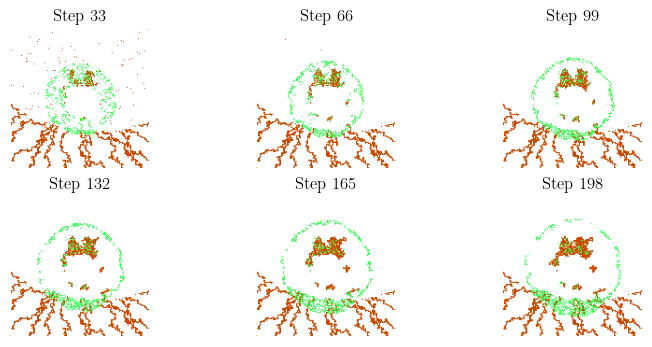

In [11]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('axes', labelsize=20) 
rc('xtick', labelsize=14)
rc('ytick',labelsize = 14)

slices = tumor.networkMovie[:,:,:,:]

fig, ax = plt.subplots(2,3,figsize = (9,4))
for i in range(0,len(frameIndexes)):
    frameIndex = frameIndexes[i]
    
    axisIndex1 = i//3
    axisIndex2 = i%3
    
    frame = slices[:,:,:,frameIndex]

    ax[axisIndex1, axisIndex2].imshow(frame)
    ax[axisIndex1, axisIndex2].set_axis_off()
    ax[axisIndex1, axisIndex2].set_title("Step "+str(frameIndex - 200))
fig.savefig('Figures/vda_automaton_example_min.pdf', format='pdf', dpi=600, bbox_inches='tight')


#tikzplotlib.save("tikz_pictures/antio_angiogenic_automaton_example_min.tex")